# Goal

The goal of this notebook is to find out if STL can be used to filter periodic signals from the orbital decay curve. I want to compare the results to the results from a simple lomb-scargle filter and see what the differences are and which method is better.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

# Data

In [2]:
from pathlib import Path

def find_repo_root(marker="README.md"):
    """Walk up from current path to find the repo root containing `marker`."""
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    raise FileNotFoundError(f"Could not find repo root with marker '{marker}'")

# Find repo root using a known file at the root
repo_root = find_repo_root("README.md")

# Path to the CSV file
GFOC_path = repo_root / Path('Dataset/Dataset_MSc/GFOC_RDCDFI.csv')

# Load only specific columns that you need for analysis
# This will significantly reduce memory usage
columns_needed = ['time', 'orbital_decay', 'se_orbital_decay']

# Try to load with limited columns first
try:
    GFOC_data = pd.read_csv(GFOC_path, usecols=columns_needed, low_memory=True)
    print(f"Successfully loaded data with shape: {GFOC_data.shape}")
except MemoryError:
    print("Still running out of memory. Loading in chunks...")
    # If still out of memory, load in chunks
    chunk_list = []
    chunksize = 50000  # Adjust this number based on your available memory
    
    for chunk in pd.read_csv(GFOC_path, usecols=columns_needed, chunksize=chunksize, low_memory=True):
        chunk_list.append(chunk)
    
    GFOC_data = pd.concat(chunk_list, ignore_index=True)
    print(f"Successfully loaded data in chunks with shape: {GFOC_data.shape}")



Successfully loaded data with shape: (1486079, 3)


Lets have a look at the raw data:

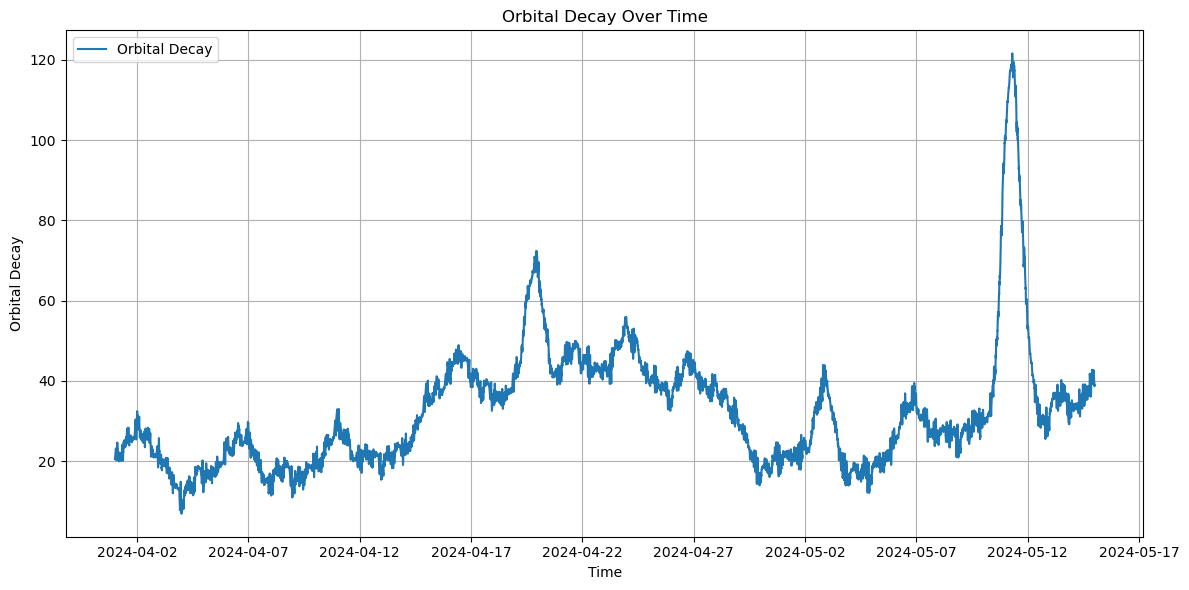

In [3]:
import matplotlib.dates as mdates
import numpy as np

# =========================== Input ===================================
start_date = '2024-04-01 00:00:00'
end_date = '2024-05-15 00:00:00'
# start_date = GFOC_data['time'].values[0]
# end_date = GFOC_data['time'].values[-4322] #removed gap by ignoring the last 4321 values

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 5  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# plt.style.use('dark_background')
plt.style.use('default')

# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=0)
# =====================================================================


# GFOC_data = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
# GFOC_time = GFOC_data['time']

GFOC_subset = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
GFOC_time = GFOC_subset['time']

# time conversion
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')

fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(GFOC_time, GFOC_data['orbital_decay'], label='Orbital Decay')
ax.plot(GFOC_time, GFOC_subset['orbital_decay'], label='Orbital Decay')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# STL filter

using a period of 10.558333333333334 hours
723 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


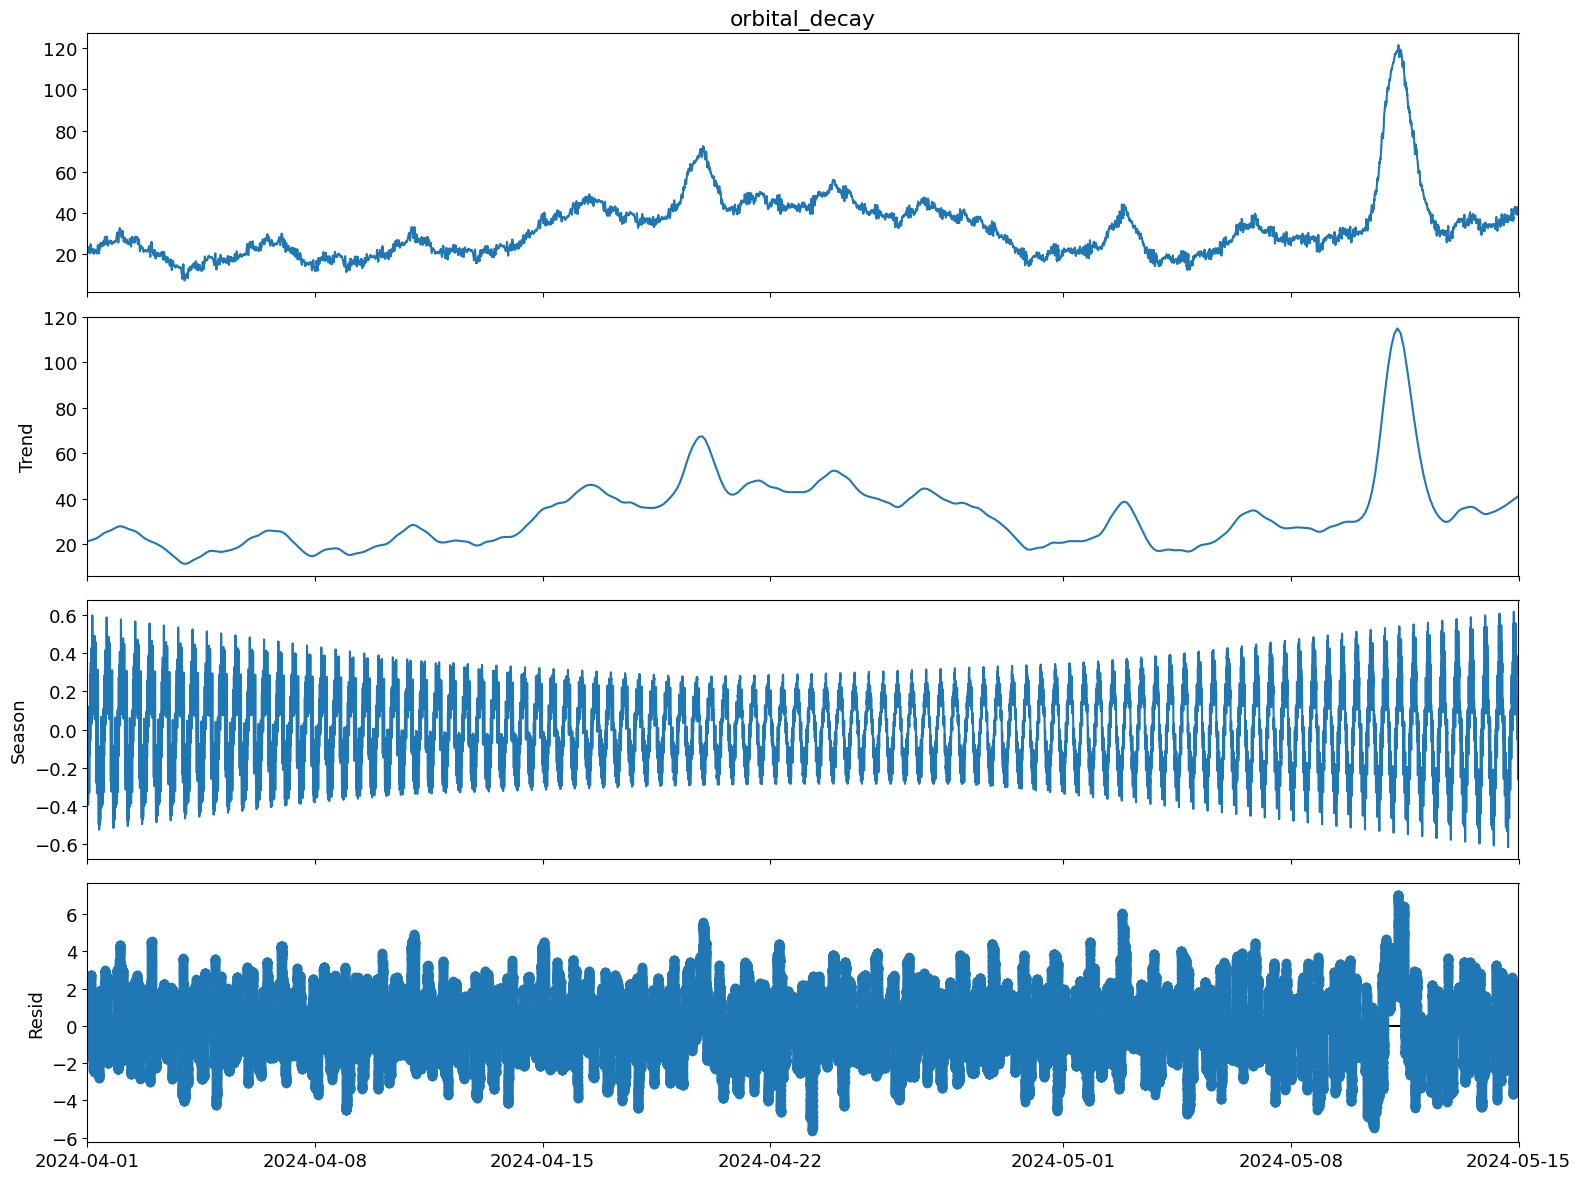

In [16]:
from statsmodels.tsa.seasonal import STL

# Use time as index for y
y = GFOC_subset[['time', 'orbital_decay']].copy()
y['time'] = pd.to_datetime(y['time'], format='%Y-%m-%d %H:%M:%S')
y.set_index('time', inplace=True)
# y.describe()

# performance
period = 1267 
print(f"using a period of {period/120} hours")
seasonal = period + ((period % 2) == 0)  # Ensure odd
low_pass_jump = seasonal_jump = int(0.15 * (period + 1))
trend_jump = int(0.15 * 1.5 * (period + 1))


mod = STL(
    y['orbital_decay'],
    period=period,
    seasonal=seasonal,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)
%timeit mod.fit()
res = mod.fit()

# plot
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)
fig = res.plot()

### Investiation of the seasonal componant


Seasonal component:
Max Seasonal amplitude: 1.8775881316748906


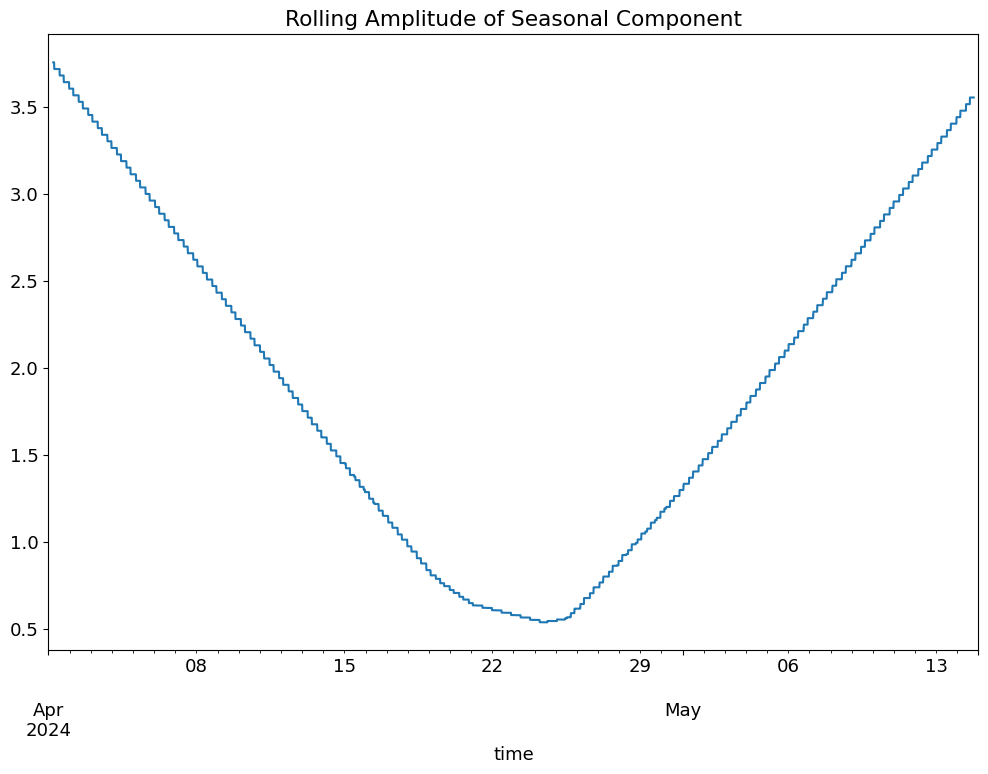

In [11]:
# Print STL decomposition results
print('\nSeasonal component:')
# print(res.seasonal.describe())

res_seasonal = res.seasonal
amplitude = (res_seasonal.max() - res_seasonal.min()) / 2
print(f"Max Seasonal amplitude: {amplitude}")

window = period  # or a fraction of it
rolling_amp = res_seasonal.rolling(window=window, center=True).apply(lambda x: x.max() - x.min())
rolling_amp.plot(title="Rolling Amplitude of Seasonal Component")
# plot
plt.rc("figure", figsize=(10, 6))
plt.rc("font", size=16)
plt.show()

# Lomb-Scargle

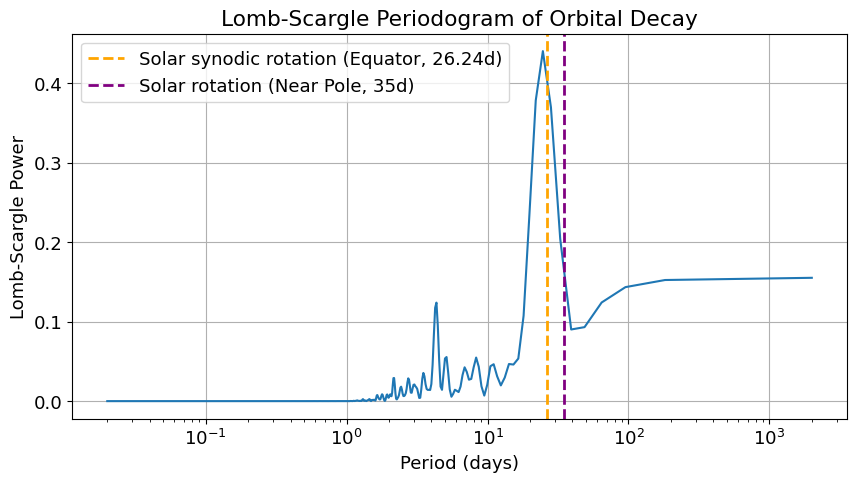

Strongest period: 24.69 days
Strongest period: 2133143.70 seconds


In [14]:
from astropy.timeseries import LombScargle


# Convert time to numerical values (in days)
times = pd.to_datetime(GFOC_subset['time'], format='%Y-%m-%d %H:%M:%S')
times_num = (times - times.iloc[0]).dt.total_seconds() / (24 * 3600)  # days since start

y = res.trend.values

# Define frequency grid (cycles per day)
min_period = 0.02   # days
max_period = 2000  # days
frequency = np.linspace(1/max_period, 1/min_period, 10000)

# Compute Lomb-Scargle periodogram
ls = LombScargle(times_num, y)
power = ls.power(frequency)

# Find the period with the highest power
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Plot the periodogram
plt.rc("figure", figsize=(10, 5))
plt.rc("font", size=13)
plt.figure()
plt.plot(1/frequency, power)
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of Orbital Decay')
plt.xscale('log')
plt.grid(True)

# Add vertical lines for solar rotation periods
plt.axvline(26.24, color='orange', linestyle='--', linewidth=2, label='Solar synodic rotation (Equator, 26.24d)')
plt.axvline(35, color='purple', linestyle='--', linewidth=2, label='Solar rotation (Near Pole, 35d)')

plt.legend()
plt.show()

print(f"Strongest period: {best_period:.2f} days")
print(f"Strongest period: {best_period*24*60*60:.2f} seconds")